# Bushfire Prediction

## Background:
The Historical Bushfire Boundaries Dataset (version 2) represents the aggregation of jurisdictional supplied burnt areas polygons that date from the early 1900s through to 2023 (excluding the Northern Territory). The burnt areas represent curated jurisdictional owned polygons of bushfires and prescribed (planned) burns.

It has the following features:

fire_id
fire_name
ignition_date
capture_date
extinguish_date
fire_type
ignition_cause
capt_method
area_ha
perim_km
state
agency
Shape__Area
Shape__Length

## Steps Involved
1. Import the libraries
2. Read the data from the csv file
3. Cleanse the data
4. Removing Outliers
5. Defining dependent and independent attributes and splitting
6. Prediction through manual fitting and Linear Regression
7. Total model accuracy
8. Other algorithms
8. Elastic model
9. XGBoost model
10. Compare model results
11. Training Xgboost with winning hyperparameters
12. Prediction leveraging xgboost

## Flowchart
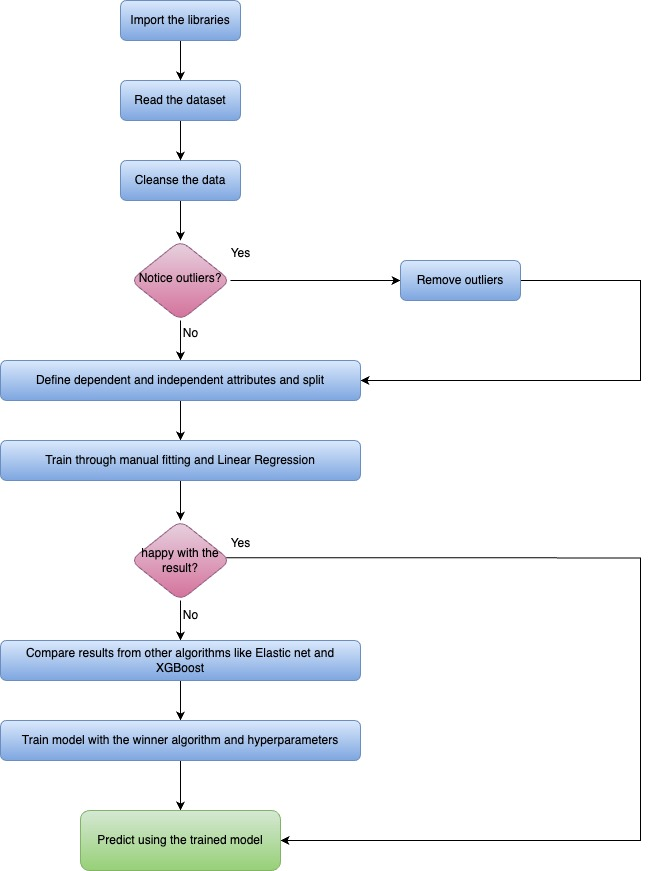

## Outcome:
1. Data was clean but imputations were required for "hybrid" column and the outliers were dropped.
2. On comparison of metrics for two different algorithms, Xgboost has outperformed other two algorithms on all three metrics (RMSE, MAE and R^2).

### Results from fitting and training

#### Elastic net

Elastic net model for ER with 10-fold CV results in:
Test rmse of 0.43766 with standard error of 0.00122.
Test mae of 0.31589 with standard error of 0.00073.
Test r2 of 0.65404 with standard error of 0.00275.

#### XGBoost

XGBoost model for ER with 10-fold CV results in:
Test rmse of 0.06597 with standard error of 0.00074.
Test mae of 0.00791 with standard error of 0.00016.
Test r2 of 0.99213 with standard error of 0.00018.


#### Best sample after using xgboost training 

`{'eta': np.float64(0.01031037901918658), 'max_depth': np.int64(18), 'min_child_weight': np.float64(3.0), 'subsample': np.float64(0.5182959940222093)}`



## Future Work:
1. The Error rate of prediction can be improved, using more data centric approach.
2. Model validations, interpretability and diagnostics need to be performed.

## Execution Steps

### Import the libraries

Prerequeisites:

1. Make sure that you have python installed
1. For the libraries that are not found, simply run `pip install <module_name>`

In [21]:
# Import

from hyperopt  import hp, fmin, tpe, Trials, STATUS_OK # type: ignore
import numpy as np
import pandas as pd
from functools import partial
import re
import sys

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from utils.eda_utils import df_overview
from utils.model_utils import *

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", 500)
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.width", 100)

# # Modeling needs
# from sklearn.metrics import r2_score 
# from sklearn.model_selection import  train_test_split 
from sklearn.linear_model import LinearRegression

# Modeling needs
from scipy.stats import sem
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler


# Modeling needs 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


### Read the data from the csv file

In [22]:
# Read the data

file = (r"Historical_Bushfire_Boundaries.csv")

df = pd.read_csv(file)
df.shape

(311984, 15)

In [23]:
df.sample(5)

,OBJECTID,fire_id,fire_name,ignition_date,capture_date,extinguish_date,fire_type,ignition_cause,capt_method,area_ha,perim_km,state,agency,Shape__Area,Shape__Length
248534,248535,NaN,Great Sandy National Park/1976/P/5,1976/01/01 00:00:00+00,NaN,NaN,Prescribed Burn,NaN,NaN,2367,28,QLD (Queensland),QPWS,2.126799e-03,0.265672
213450,213451,999,,2012/07/01 00:00:00+00,NaN,NaN,Unknown,NaN,Landsat,2,1,WA (Western Australia),WA DFES,1.740005e-06,0.006081
135544,135545,268,Murray Sunset - Walker Road,2019/05/19 00:00:00+00,NaN,NaN,Prescribed Burn,NaN,NaN,0,0,VIC (Victoria),VIC DEECA,9.989435e-09,0.000402
24690,24691,999,NaN,2016/11/05 00:00:00+00,NaN,NaN,Unknown,NaN,Landsat,715,52,WA (Western Australia),WA DFES,6.890289e-04,0.432032
251851,251852,999,,1939/09/16 00:00:00+00,NaN,NaN,Prescribed Burn,NaN,Aerial photography,49,4,WA (Western Australia),WA DFES,4.711023e-05,0.039802


In [24]:
df.describe()

,OBJECTID,area_ha,perim_km,Shape__Area,Shape__Length
count,311984.000000,3.119840e+05,311984.000000,3.119840e+05,3.119840e+05
mean,155992.500000,2.296942e+03,52.401777,1.022608e-03,1.141268e-01
std,90062.167529,4.620564e+04,837.033427,1.817445e-02,5.491933e-01
min,1.000000,0.000000e+00,0.000000,0.000000e+00,1.437568e-07
25%,77996.750000,1.000000e+00,0.000000,8.348505e-07,4.268383e-03
50%,155992.500000,9.000000e+00,2.000000,8.281588e-06,1.618414e-02
75%,233988.250000,8.500000e+01,6.000000,8.164109e-05,5.942387e-02
max,311984.000000,5.763897e+06,47692.000000,3.665107e+00,3.256993e+01


In [25]:
df_overview(df)

,column_label,type,uniques_values,non_null_values,null_values,null_value_pct
0,OBJECTID,int64,311984,311984,0,0.00
1,fire_id,object,35318,277309,34675,11.11
2,fire_name,object,53165,234544,77440,24.82
3,ignition_date,object,13023,295525,16459,5.28
4,capture_date,object,56,258,311726,99.92
5,extinguish_date,object,8564,28186,283798,90.97
6,fire_type,object,3,311983,1,0.00
7,ignition_cause,object,6,17986,293998,94.23
8,capt_method,object,10,173552,138432,44.37
9,area_ha,int64,10595,311984,0,0.00


### Cleanse the data

This can be achieved by:
1. Removing null rows
2. Dropping irrelevant columns
3. Removing rows where significant columns have null values

In [26]:
# Delete the rows without any data
df_filtered = df.dropna(how='all').copy()
df_filtered = df_filtered[df_filtered['ignition_date'].notna()]


df_filtered = df_filtered.drop(["fire_name","capt_method", "capture_date","extinguish_date","ignition_cause","agency","fire_id"], axis=1)
df_filtered['ignition_month'] = pd.to_datetime(df_filtered['ignition_date']).dt.month
df_filtered['ignition_year'] = pd.to_datetime(df_filtered['ignition_date']).dt.year
df_filtered[df_filtered["fire_type"]=='Bushfire']




,OBJECTID,ignition_date,fire_type,area_ha,perim_km,state,Shape__Area,Shape__Length,ignition_month,ignition_year
5,6,2009/12/05 00:00:00+00,Bushfire,22392,91,NSW (New South Wales),2.080501e-02,0.857105,12,2009
9,10,1964/01/01 00:00:00+00,Bushfire,6,1,VIC (Victoria),6.625814e-06,0.010814,1,1964
17,18,2014/03/23 00:00:00+00,Bushfire,1,0,WA (Western Australia),6.076364e-07,0.002778,3,2014
18,19,2012/12/04 00:00:00+00,Bushfire,539,12,NSW (New South Wales),5.254276e-04,0.123374,12,2012
22,23,1994/12/31 00:00:00+00,Bushfire,7,1,SA (South Australia),6.753079e-06,0.011657,12,1994
...,...,...,...,...,...,...,...,...,...,...
311977,311978,2021/11/17 00:00:00+00,Bushfire,12511,685,WA (Western Australia),4.307718e-04,0.175473,11,2021
311978,311979,2009/11/16 00:00:00+00,Bushfire,50675,3439,WA (Western Australia),3.950349e-02,3.816505,11,2009
311979,311980,2009/11/16 00:00:00+00,Bushfire,50675,3439,WA (Western Australia),1.379611e-02,1.714208,11,2009
311980,311981,2023/03/02 00:00:00+00,Bushfire,9129,845,WA (Western Australia),6.849221e-03,1.097727,3,2023


In [27]:
df_overview(df_filtered)


,column_label,type,uniques_values,non_null_values,null_values,null_value_pct
0,OBJECTID,int64,295525,295525,0,0.0
1,ignition_date,object,13023,295525,0,0.0
2,fire_type,object,3,295524,1,0.0
3,area_ha,int64,10267,295525,0,0.0
4,perim_km,int64,1590,295525,0,0.0
5,state,object,7,295525,0,0.0
6,Shape__Area,float64,263751,295525,0,0.0
7,Shape__Length,float64,294007,295525,0,0.0
8,ignition_month,int32,12,295525,0,0.0
9,ignition_year,int32,104,295525,0,0.0


In [28]:
df_filtered.describe()

,OBJECTID,area_ha,perim_km,Shape__Area,Shape__Length,ignition_month,ignition_year
count,295525.000000,2.955250e+05,295525.000000,2.955250e+05,2.955250e+05,295525.000000,295525.000000
mean,156085.677560,2.358811e+03,54.807468,1.015214e-03,1.158782e-01,5.736005,1999.739545
std,90093.397931,4.689238e+04,859.872719,1.708296e-02,5.580353e-01,3.707010,20.850280
min,1.000000,0.000000e+00,0.000000,0.000000e+00,1.437568e-07,1.000000,1899.000000
25%,78117.000000,1.000000e+00,0.000000,7.543808e-07,4.061542e-03,2.000000,1992.000000
50%,156023.000000,8.000000e+00,2.000000,7.634300e-06,1.562001e-02,5.000000,2005.000000
75%,234105.000000,8.100000e+01,6.000000,7.733513e-05,5.846122e-02,9.000000,2016.000000
max,311984.000000,5.763897e+06,47692.000000,3.665107e+00,3.256993e+01,12.000000,2023.000000


In [29]:
df_filtered.sample(5)

,OBJECTID,ignition_date,fire_type,area_ha,perim_km,state,Shape__Area,Shape__Length,ignition_month,ignition_year
240071,240072,2021/04/18 00:00:00+00,Prescribed Burn,0,0,VIC (Victoria),8.860707e-08,0.002032,4,2021
152106,152107,1970/09/16 00:00:00+00,Prescribed Burn,331,13,WA (Western Australia),3.191528e-04,0.128879,9,1970
248569,248570,1994/01/01 00:00:00+00,Unknown,3,1,WA (Western Australia),2.814305e-06,0.010114,1,1994
132848,132849,2020/04/06 00:00:00+00,Bushfire,0,0,WA (Western Australia),9.471796e-08,0.001097,4,2020
20818,20819,1969/01/01 00:00:00+00,Unknown,1,0,WA (Western Australia),9.667062e-07,0.004063,1,1969


Text(0, 0.5, 'Area in Hectares')

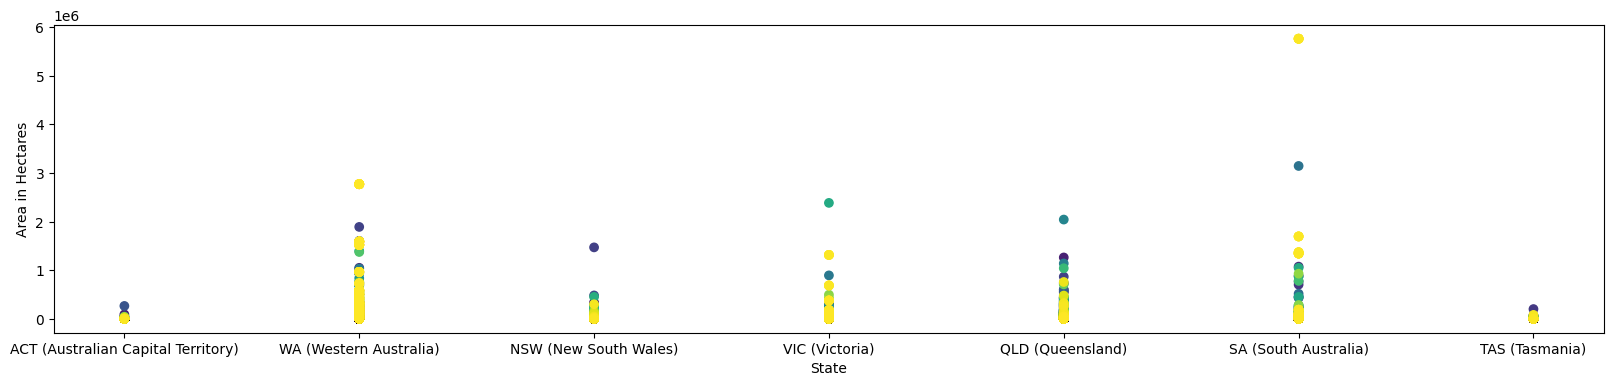

In [30]:
xdata = df_filtered["state"]  # Setting the x values
ydata = df_filtered["area_ha"]  # setting the y values
t = np.arange(295525)

plt.figure(figsize = (20,4)) # set the size of the figure
plt.scatter(xdata, ydata, c=t) # scatter plot of the data
plt.xlabel("State")
plt.ylabel("Area in Hectares")

Text(0, 0.5, 'Area in Hectares')

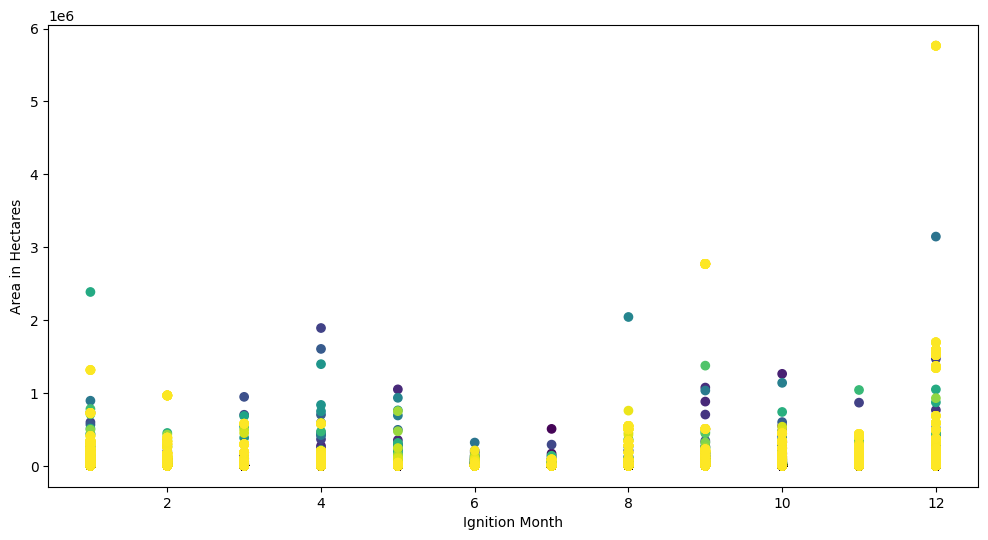

In [31]:
xdata = df_filtered["ignition_month"]  # setting the x values
ydata = df_filtered["area_ha"]  # Setting the y values
t = np.arange(295525)

plt.figure(figsize = (12,6)) # set the size of the figure
plt.scatter(xdata, ydata, c=t) # scatter plot of the data
plt.xlabel("Ignition Month")
plt.ylabel("Area in Hectares")

Text(0, 0.5, 'Area in Hectares')

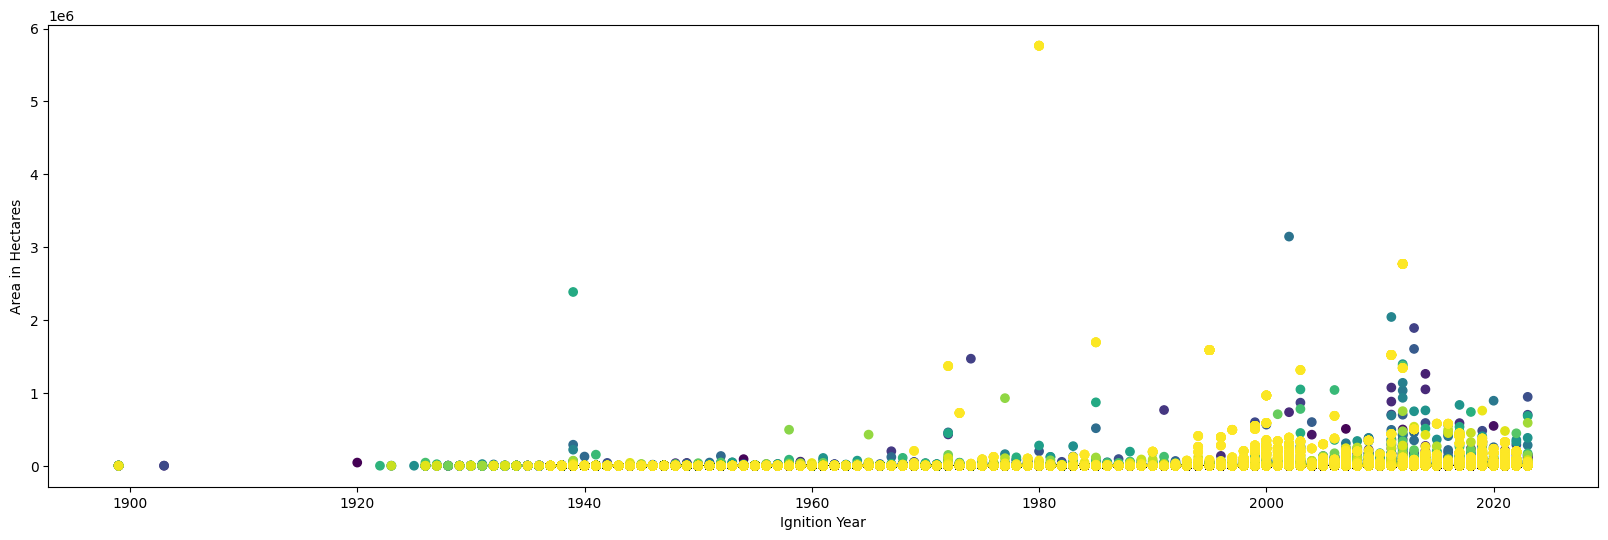

In [32]:
xdata = df_filtered["ignition_year"]  # setting the x values
ydata = df_filtered["area_ha"]  # Setting the y values
t = np.arange(295525)

plt.figure(figsize = (20,6)) # set the size of the figure
plt.scatter(xdata, ydata, c=t) # scatter plot of the data
plt.xlabel("Ignition Year")
plt.ylabel("Area in Hectares")

### Removing Outliers

In [33]:
df_filtered = df_filtered[
    (df_filtered["area_ha"] < 3) & (df_filtered["ignition_year"]>1970)
]

df_overview(df_filtered)

,column_label,type,uniques_values,non_null_values,null_values,null_value_pct
0,OBJECTID,int64,105296,105296,0,0.0
1,ignition_date,object,7791,105296,0,0.0
2,fire_type,object,3,105296,0,0.0
3,area_ha,int64,3,105296,0,0.0
4,perim_km,int64,7,105296,0,0.0
5,state,object,7,105296,0,0.0
6,Shape__Area,float64,74870,105296,0,0.0
7,Shape__Length,float64,104817,105296,0,0.0
8,ignition_month,int32,12,105296,0,0.0
9,ignition_year,int32,53,105296,0,0.0


/var/folders/n9/t0w7xncd63lg68n__n_7mc940000gq/T/ipykernel_28644/528409917.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtered,y="area_ha",orient="v",ax=axes[0][0],palette="deep")
/var/folders/n9/t0w7xncd63lg68n__n_7mc940000gq/T/ipykernel_28644/528409917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtered,y="area_ha",x="ignition_year",orient="v",ax=axes[0][1],palette="deep")
/var/folders/n9/t0w7xncd63lg68n__n_7mc940000gq/T/ipykernel_28644/528409917.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot

[Text(0.5, 0, 'Bushfire state'),
 Text(0, 0.5, 'Area in Hectares'),
 Text(0.5, 1.0, 'Box Plot On Area Across State')]

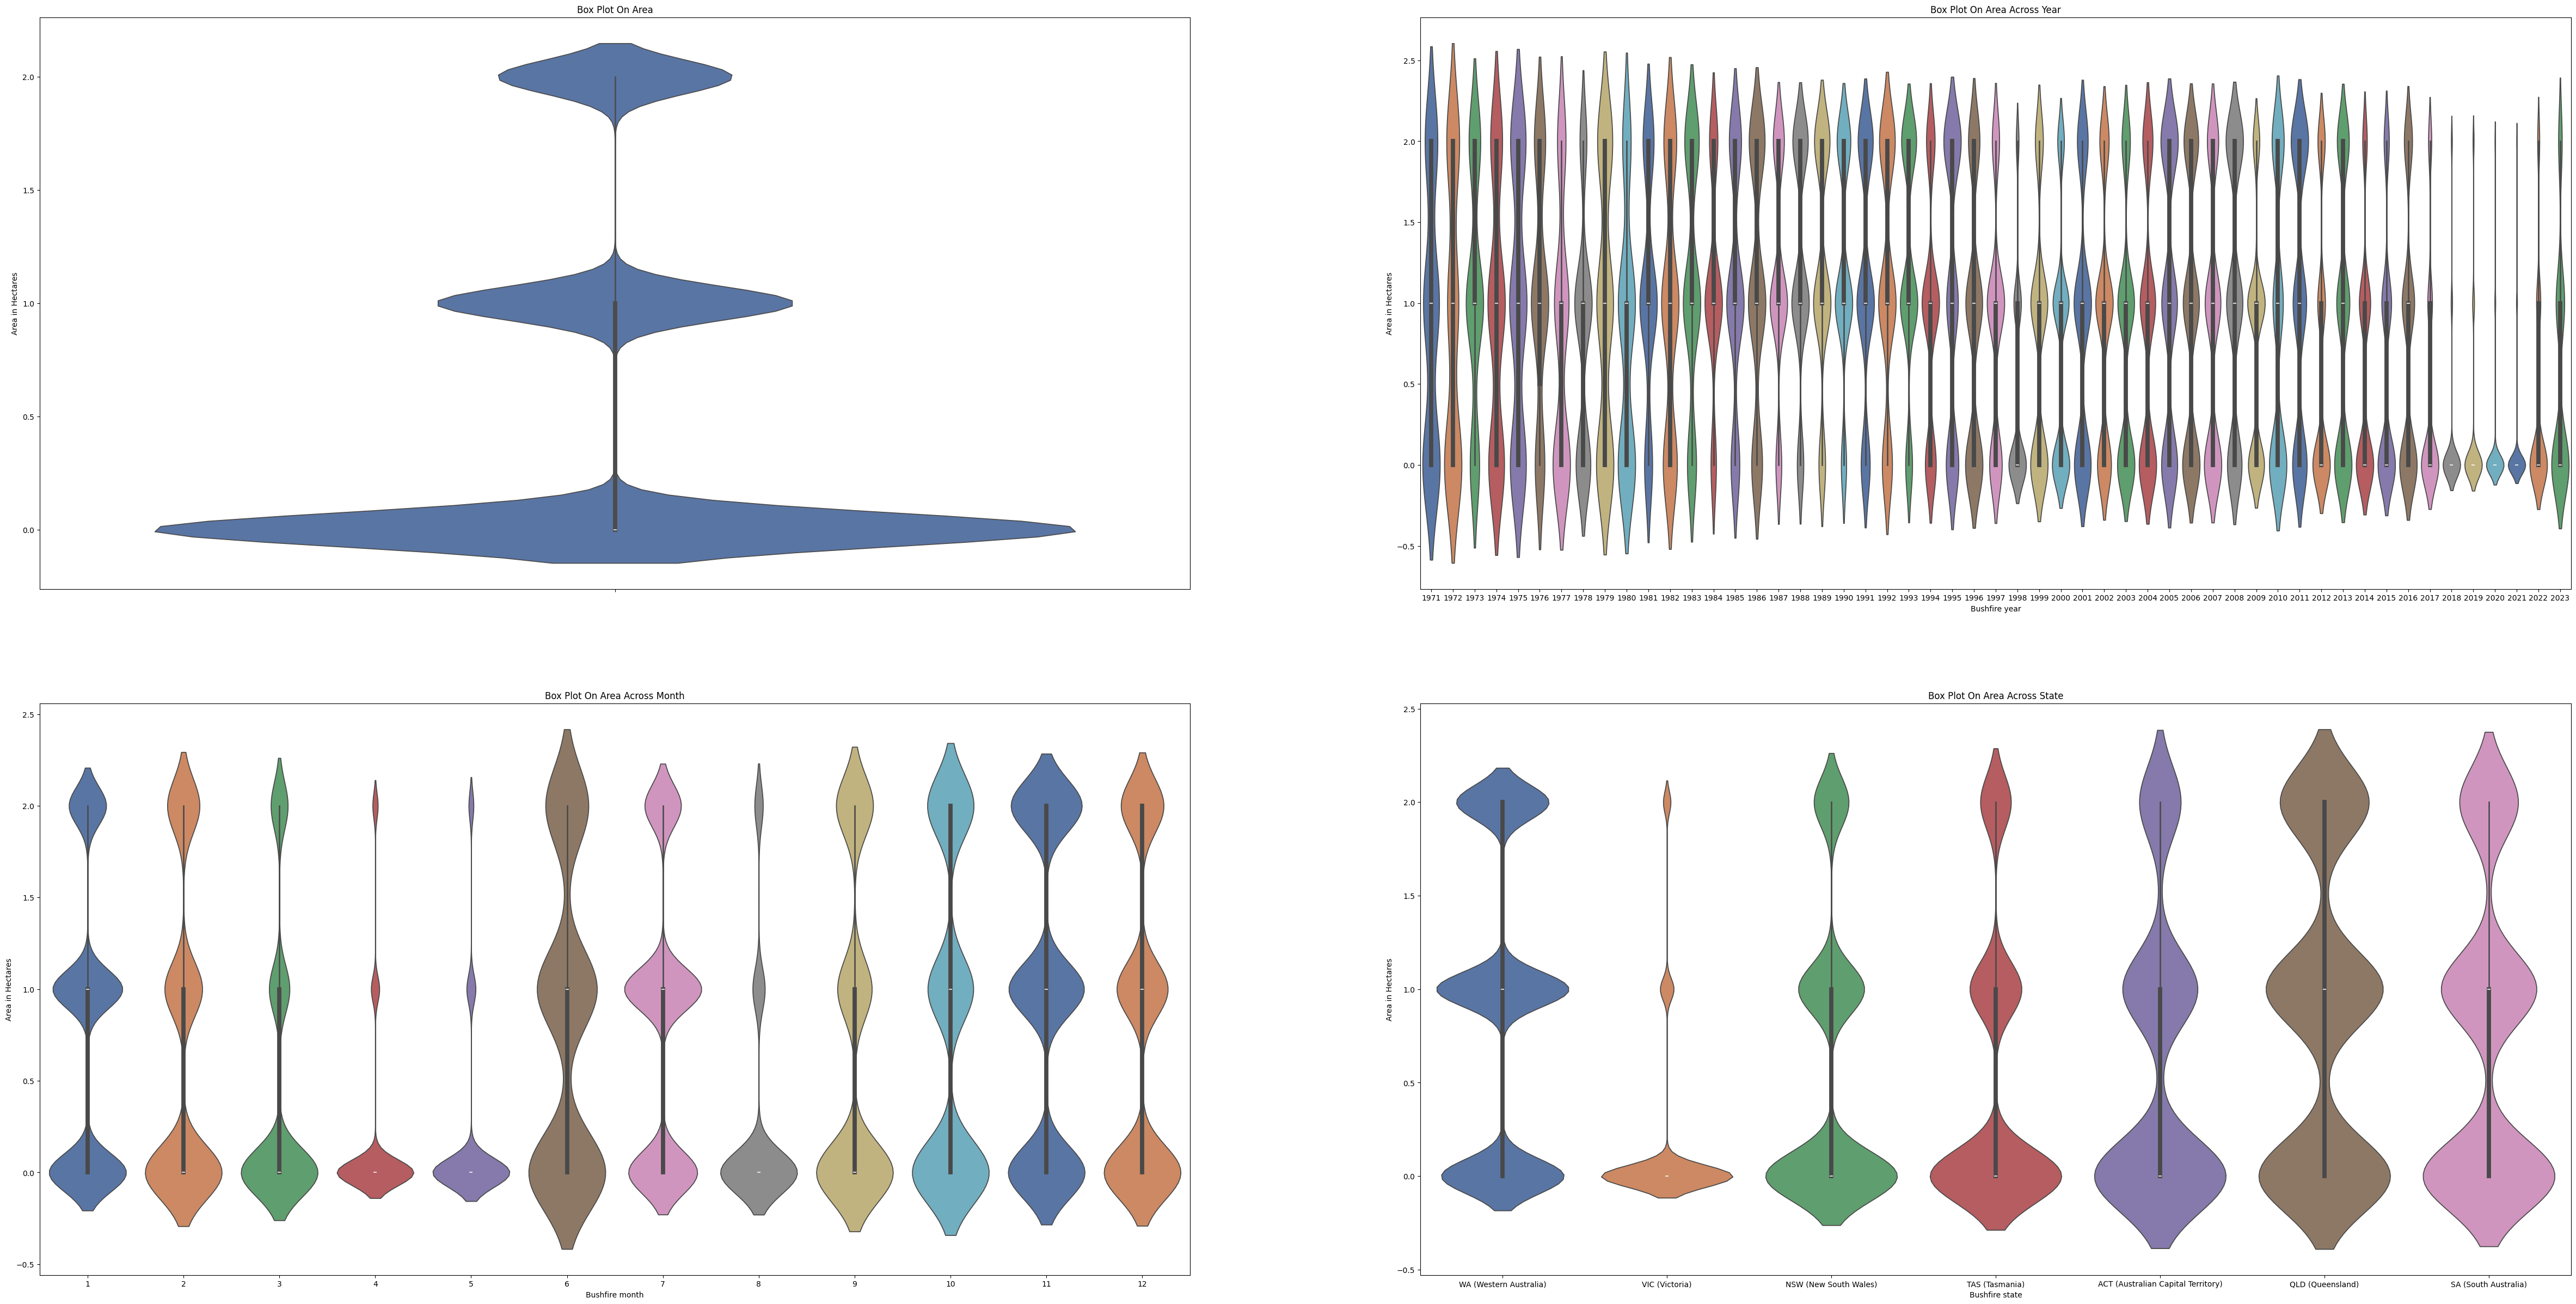

In [34]:
# explore categorical features
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(60, 30)
sns.violinplot(data=df_filtered,y="area_ha",orient="v",ax=axes[0][0],palette="deep")
sns.violinplot(data=df_filtered,y="area_ha",x="ignition_year",orient="v",ax=axes[0][1],palette="deep")
sns.violinplot(data=df_filtered,y="area_ha",x="ignition_month",orient="v",ax=axes[1][0],palette="deep")
sns.violinplot(data=df_filtered,y="area_ha",x="state",orient="v",ax=axes[1][1],palette="deep")
sns.color_palette("YlOrBr", as_cmap=True)



axes[0][0].set(ylabel='Area in Hectares',title="Box Plot On Area")
axes[0][1].set(xlabel='Bushfire year', ylabel='Area in Hectares',title="Box Plot On Area Across Year")
axes[1][0].set(xlabel='Bushfire month', ylabel='Area in Hectares',title="Box Plot On Area Across Month")
axes[1][1].set(xlabel='Bushfire state', ylabel='Area in Hectares',title="Box Plot On Area Across State")


### Defining dependent and independent attributes and splitting

In [35]:
x = df_filtered[["ignition_year","ignition_month","perim_km"]]
y = df_filtered["area_ha"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.8, random_state = 3)

In [36]:
ml= LinearRegression()
ml.fit(x_train,y_train)

LinearRegression()

### Prediction through manual fitting

In [37]:
y_pred=ml.predict(x_test)
print(y_pred)

[0.5139 0.1154 0.1706 ... 0.4263 0.6549 1.4006]


### Total model accuracy

In [38]:
r2_score(y_test,y_pred)

0.569357043252887

##### Since our model accuracy using linear regression and manual variable fitting is less, we look for better  alternatives. We test our model with other algorithms such as elastic and xgboost targeting the area attribute. 

### Other algorithms

In [39]:
# Global variable
METRICS = ["rmse", "mae", "r2"]
N_FOLD = 10
SEED = 66
TARGET_VAR = "area_ha"

# Create dummies
df_final = df_filtered.copy()

X_interm = pd.get_dummies(df_final, columns=['state', 'ignition_date', 'fire_type'])

In [40]:
# Trainng data selection
X_interm_1 = X_interm[X_interm["ignition_year"] > 1980]
X_interm_1.shape

# df_filtered.drop(['datetime'], axis=1, inplace=True)
X = X_interm_1.drop(['area_ha',], axis=1).copy()

Y = X_interm_1[[TARGET_VAR]].copy()

### Elastic model

In [41]:

# Initiate elastic net model

enet = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=SEED)

# Create model wrapper
def linear_train_and_predict(X_train_tmp, X_test_tmp, Y_train_tmp, Y_test_tmp):
    enet.fit(X_train_tmp, Y_train_tmp[TARGET_VAR])
    
    prediction_train_tmp = enet.predict(X_train_tmp)
    prediction_test_tmp = enet.predict(X_test_tmp)
    
    return prediction_train_tmp, prediction_test_tmp

df_cv_scores_elastic_net = k_fold_cv_results(linear_train_and_predict, X, Y, TARGET_VAR, n_splits=N_FOLD)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

In [42]:
model_result_summary(df_cv_scores_elastic_net, N_FOLD, "Elastic net model", METRICS)

Elastic net model for ER with 10-fold CV results in:
Test rmse of 0.43766 with standard error of 0.00122.
Test mae of 0.31589 with standard error of 0.00073.
Test r2 of 0.65404 with standard error of 0.00275.


### XGBoost Model

In [43]:
# Create an initial parameter list

params = {
    "max_depth": 13,
    "min_child_weight": 1,
    "eta": 0.2,
    "subsample": 1,
    "colsample_bytree": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": SEED,
}

# Set num_boost_rounds and early stopping rounds
num_boost_rounds = 2000
early_stopping_rounds = 10

# Create model wrapper

def xgboost_train_and_predict(X_train_tmp, X_test_tmp, Y_train_tmp, Y_test_tmp):
    dtrain_tmp = xgb.DMatrix(X_train_tmp, label=Y_train_tmp[TARGET_VAR])
    dtest_tmp = xgb.DMatrix(X_test_tmp, label=Y_test_tmp[TARGET_VAR])
    
    xbg_model = xgb.train(
        params,
        dtrain_tmp,
        num_boost_round=num_boost_rounds,
        evals=[((dtest_tmp, "test"))],
        early_stopping_rounds=early_stopping_rounds,
    )
    
    prediction_train_tmp = xbg_model.predict(dtrain_tmp)
    prediction_test_tmp = xbg_model.predict(dtest_tmp)
    
    return prediction_train_tmp, prediction_test_tmp

    # Cross validation model training

df_cv_scores_xgboost = k_fold_cv_results(xgboost_train_and_predict, X, Y, TARGET_VAR, n_splits=N_FOLD)


[0]	test-rmse:0.59529
[1]	test-rmse:0.47783
[2]	test-rmse:0.38426
[3]	test-rmse:0.30978
[4]	test-rmse:0.25090
[5]	test-rmse:0.20438
[6]	test-rmse:0.16813
[7]	test-rmse:0.13980
[8]	test-rmse:0.11820
[9]	test-rmse:0.10213
[10]	test-rmse:0.09028
[11]	test-rmse:0.08183
[12]	test-rmse:0.07593
[13]	test-rmse:0.07198
[14]	test-rmse:0.06939
[15]	test-rmse:0.06738
[16]	test-rmse:0.06611
[17]	test-rmse:0.06534
[18]	test-rmse:0.06493
[19]	test-rmse:0.06456
[20]	test-rmse:0.06439
[21]	test-rmse:0.06426
[22]	test-rmse:0.06413
[23]	test-rmse:0.06408
[24]	test-rmse:0.06406
[25]	test-rmse:0.06409
[26]	test-rmse:0.06409
[27]	test-rmse:0.06408
[28]	test-rmse:0.06408
[29]	test-rmse:0.06408
[30]	test-rmse:0.06408
[31]	test-rmse:0.06406
[32]	test-rmse:0.06406
[33]	test-rmse:0.06406
[34]	test-rmse:0.06408
[35]	test-rmse:0.06407
[36]	test-rmse:0.06407
[37]	test-rmse:0.06411
[38]	test-rmse:0.06411
[39]	test-rmse:0.06411
[40]	test-rmse:0.06412


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59874
[1]	test-rmse:0.48101
[2]	test-rmse:0.38749
[3]	test-rmse:0.31298
[4]	test-rmse:0.25401
[5]	test-rmse:0.20746
[6]	test-rmse:0.17121
[7]	test-rmse:0.14340
[8]	test-rmse:0.12236
[9]	test-rmse:0.10668
[10]	test-rmse:0.09531
[11]	test-rmse:0.08725
[12]	test-rmse:0.08180
[13]	test-rmse:0.07805
[14]	test-rmse:0.07553
[15]	test-rmse:0.07413
[16]	test-rmse:0.07302
[17]	test-rmse:0.07227
[18]	test-rmse:0.07190
[19]	test-rmse:0.07169
[20]	test-rmse:0.07154
[21]	test-rmse:0.07144
[22]	test-rmse:0.07138
[23]	test-rmse:0.07132
[24]	test-rmse:0.07129
[25]	test-rmse:0.07128
[26]	test-rmse:0.07133
[27]	test-rmse:0.07133
[28]	test-rmse:0.07131
[29]	test-rmse:0.07130
[30]	test-rmse:0.07128
[31]	test-rmse:0.07128
[32]	test-rmse:0.07129
[33]	test-rmse:0.07130
[34]	test-rmse:0.07128
[35]	test-rmse:0.07128
[36]	test-rmse:0.07129
[37]	test-rmse:0.07129
[38]	test-rmse:0.07129
[39]	test-rmse:0.07129
[40]	test-rmse:0.07129
[41]	test-rmse:0.07129


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.60110
[1]	test-rmse:0.48249
[2]	test-rmse:0.38797
[3]	test-rmse:0.31283
[4]	test-rmse:0.25326
[5]	test-rmse:0.20630
[6]	test-rmse:0.16928
[7]	test-rmse:0.14060
[8]	test-rmse:0.11871
[9]	test-rmse:0.10242
[10]	test-rmse:0.09060
[11]	test-rmse:0.08201
[12]	test-rmse:0.07608
[13]	test-rmse:0.07200
[14]	test-rmse:0.06906
[15]	test-rmse:0.06726
[16]	test-rmse:0.06609
[17]	test-rmse:0.06535
[18]	test-rmse:0.06487
[19]	test-rmse:0.06460
[20]	test-rmse:0.06442
[21]	test-rmse:0.06424
[22]	test-rmse:0.06416
[23]	test-rmse:0.06412
[24]	test-rmse:0.06408
[25]	test-rmse:0.06407
[26]	test-rmse:0.06406
[27]	test-rmse:0.06406
[28]	test-rmse:0.06404
[29]	test-rmse:0.06403
[30]	test-rmse:0.06403
[31]	test-rmse:0.06401
[32]	test-rmse:0.06402
[33]	test-rmse:0.06403
[34]	test-rmse:0.06403
[35]	test-rmse:0.06402
[36]	test-rmse:0.06402
[37]	test-rmse:0.06402
[38]	test-rmse:0.06402
[39]	test-rmse:0.06403
[40]	test-rmse:0.06402
[41]	test-rmse:0.06403


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59787
[1]	test-rmse:0.47991
[2]	test-rmse:0.38592
[3]	test-rmse:0.31103
[4]	test-rmse:0.25195
[5]	test-rmse:0.20517
[6]	test-rmse:0.16872
[7]	test-rmse:0.14051
[8]	test-rmse:0.11906
[9]	test-rmse:0.10321
[10]	test-rmse:0.09162
[11]	test-rmse:0.08337
[12]	test-rmse:0.07765
[13]	test-rmse:0.07377
[14]	test-rmse:0.07113
[15]	test-rmse:0.06950
[16]	test-rmse:0.06852
[17]	test-rmse:0.06784
[18]	test-rmse:0.06749
[19]	test-rmse:0.06716
[20]	test-rmse:0.06703
[21]	test-rmse:0.06696
[22]	test-rmse:0.06691
[23]	test-rmse:0.06688
[24]	test-rmse:0.06687
[25]	test-rmse:0.06687
[26]	test-rmse:0.06689
[27]	test-rmse:0.06690
[28]	test-rmse:0.06690
[29]	test-rmse:0.06690
[30]	test-rmse:0.06693
[31]	test-rmse:0.06693
[32]	test-rmse:0.06693
[33]	test-rmse:0.06694
[34]	test-rmse:0.06694


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.58875
[1]	test-rmse:0.47296
[2]	test-rmse:0.38054
[3]	test-rmse:0.30699
[4]	test-rmse:0.24876
[5]	test-rmse:0.20283
[6]	test-rmse:0.16712
[7]	test-rmse:0.13912
[8]	test-rmse:0.11820
[9]	test-rmse:0.10246
[10]	test-rmse:0.09112
[11]	test-rmse:0.08283
[12]	test-rmse:0.07720
[13]	test-rmse:0.07329
[14]	test-rmse:0.07062
[15]	test-rmse:0.06920
[16]	test-rmse:0.06812
[17]	test-rmse:0.06739
[18]	test-rmse:0.06689
[19]	test-rmse:0.06657
[20]	test-rmse:0.06640
[21]	test-rmse:0.06624
[22]	test-rmse:0.06615
[23]	test-rmse:0.06608
[24]	test-rmse:0.06622
[25]	test-rmse:0.06617
[26]	test-rmse:0.06616
[27]	test-rmse:0.06617
[28]	test-rmse:0.06617
[29]	test-rmse:0.06617
[30]	test-rmse:0.06619
[31]	test-rmse:0.06617
[32]	test-rmse:0.06615
[33]	test-rmse:0.06615


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59484
[1]	test-rmse:0.47768
[2]	test-rmse:0.38424
[3]	test-rmse:0.30988
[4]	test-rmse:0.25085
[5]	test-rmse:0.20437
[6]	test-rmse:0.16812
[7]	test-rmse:0.13972
[8]	test-rmse:0.11816
[9]	test-rmse:0.10204
[10]	test-rmse:0.09018
[11]	test-rmse:0.08164
[12]	test-rmse:0.07576
[13]	test-rmse:0.07157
[14]	test-rmse:0.06876
[15]	test-rmse:0.06694
[16]	test-rmse:0.06571
[17]	test-rmse:0.06490
[18]	test-rmse:0.06436
[19]	test-rmse:0.06406
[20]	test-rmse:0.06385
[21]	test-rmse:0.06376
[22]	test-rmse:0.06373
[23]	test-rmse:0.06368
[24]	test-rmse:0.06366
[25]	test-rmse:0.06365
[26]	test-rmse:0.06364
[27]	test-rmse:0.06358
[28]	test-rmse:0.06353
[29]	test-rmse:0.06353
[30]	test-rmse:0.06352
[31]	test-rmse:0.06350
[32]	test-rmse:0.06350
[33]	test-rmse:0.06350
[34]	test-rmse:0.06355
[35]	test-rmse:0.06354
[36]	test-rmse:0.06354
[37]	test-rmse:0.06353
[38]	test-rmse:0.06353
[39]	test-rmse:0.06354
[40]	test-rmse:0.06354
[41]	test-rmse:0.06353
[42]	test-rmse:0.06354
[43]	test-rmse:0.0635

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59863
[1]	test-rmse:0.48071
[2]	test-rmse:0.38652
[3]	test-rmse:0.31176
[4]	test-rmse:0.25246
[5]	test-rmse:0.20578
[6]	test-rmse:0.16934
[7]	test-rmse:0.14105
[8]	test-rmse:0.11969
[9]	test-rmse:0.10369
[10]	test-rmse:0.09216
[11]	test-rmse:0.08395
[12]	test-rmse:0.07815
[13]	test-rmse:0.07419
[14]	test-rmse:0.07185
[15]	test-rmse:0.06999
[16]	test-rmse:0.06873
[17]	test-rmse:0.06803
[18]	test-rmse:0.06770
[19]	test-rmse:0.06748
[20]	test-rmse:0.06733
[21]	test-rmse:0.06725
[22]	test-rmse:0.06720
[23]	test-rmse:0.06719
[24]	test-rmse:0.06723
[25]	test-rmse:0.06722
[26]	test-rmse:0.06721
[27]	test-rmse:0.06720
[28]	test-rmse:0.06723
[29]	test-rmse:0.06724
[30]	test-rmse:0.06725
[31]	test-rmse:0.06724
[32]	test-rmse:0.06723


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59638
[1]	test-rmse:0.47885
[2]	test-rmse:0.38528
[3]	test-rmse:0.31083
[4]	test-rmse:0.25201
[5]	test-rmse:0.20537
[6]	test-rmse:0.16886
[7]	test-rmse:0.14085
[8]	test-rmse:0.11960
[9]	test-rmse:0.10343
[10]	test-rmse:0.09150
[11]	test-rmse:0.08343
[12]	test-rmse:0.07744
[13]	test-rmse:0.07355
[14]	test-rmse:0.07092
[15]	test-rmse:0.06922
[16]	test-rmse:0.06819
[17]	test-rmse:0.06751
[18]	test-rmse:0.06711
[19]	test-rmse:0.06688
[20]	test-rmse:0.06666
[21]	test-rmse:0.06653
[22]	test-rmse:0.06645
[23]	test-rmse:0.06636
[24]	test-rmse:0.06640
[25]	test-rmse:0.06638
[26]	test-rmse:0.06638
[27]	test-rmse:0.06644
[28]	test-rmse:0.06646
[29]	test-rmse:0.06646
[30]	test-rmse:0.06649
[31]	test-rmse:0.06650
[32]	test-rmse:0.06646
[33]	test-rmse:0.06646


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59752
[1]	test-rmse:0.47949
[2]	test-rmse:0.38533
[3]	test-rmse:0.31052
[4]	test-rmse:0.25139
[5]	test-rmse:0.20472
[6]	test-rmse:0.16816
[7]	test-rmse:0.13977
[8]	test-rmse:0.11802
[9]	test-rmse:0.10182
[10]	test-rmse:0.08988
[11]	test-rmse:0.08134
[12]	test-rmse:0.07529
[13]	test-rmse:0.07144
[14]	test-rmse:0.06901
[15]	test-rmse:0.06728
[16]	test-rmse:0.06600
[17]	test-rmse:0.06526
[18]	test-rmse:0.06482
[19]	test-rmse:0.06433
[20]	test-rmse:0.06410
[21]	test-rmse:0.06401
[22]	test-rmse:0.06394
[23]	test-rmse:0.06388
[24]	test-rmse:0.06389
[25]	test-rmse:0.06387
[26]	test-rmse:0.06386
[27]	test-rmse:0.06386
[28]	test-rmse:0.06386
[29]	test-rmse:0.06387
[30]	test-rmse:0.06390
[31]	test-rmse:0.06390
[32]	test-rmse:0.06390
[33]	test-rmse:0.06391
[34]	test-rmse:0.06391
[35]	test-rmse:0.06388
[36]	test-rmse:0.06388
[37]	test-rmse:0.06388


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.59861
[1]	test-rmse:0.48058
[2]	test-rmse:0.38666
[3]	test-rmse:0.31203
[4]	test-rmse:0.25273
[5]	test-rmse:0.20613
[6]	test-rmse:0.16959
[7]	test-rmse:0.14132
[8]	test-rmse:0.11970
[9]	test-rmse:0.10370
[10]	test-rmse:0.09197
[11]	test-rmse:0.08360
[12]	test-rmse:0.07771
[13]	test-rmse:0.07376
[14]	test-rmse:0.07113
[15]	test-rmse:0.06944
[16]	test-rmse:0.06818
[17]	test-rmse:0.06733
[18]	test-rmse:0.06699
[19]	test-rmse:0.06663
[20]	test-rmse:0.06646
[21]	test-rmse:0.06634
[22]	test-rmse:0.06626
[23]	test-rmse:0.06622
[24]	test-rmse:0.06618
[25]	test-rmse:0.06617
[26]	test-rmse:0.06616
[27]	test-rmse:0.06613
[28]	test-rmse:0.06614
[29]	test-rmse:0.06614
[30]	test-rmse:0.06614
[31]	test-rmse:0.06614
[32]	test-rmse:0.06614
[33]	test-rmse:0.06614
[34]	test-rmse:0.06614
[35]	test-rmse:0.06610
[36]	test-rmse:0.06610
[37]	test-rmse:0.06609
[38]	test-rmse:0.06609
[39]	test-rmse:0.06608
[40]	test-rmse:0.06608
[41]	test-rmse:0.06608
[42]	test-rmse:0.06608
[43]	test-rmse:0.0660

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# Print out model result summary across 10 CVs

model_result_summary(df_cv_scores_xgboost, N_FOLD, "XGBoost model", METRICS)

XGBoost model for ER with 10-fold CV results in:
Test rmse of 0.06597 with standard error of 0.00074.
Test mae of 0.00791 with standard error of 0.00016.
Test r2 of 0.99213 with standard error of 0.00018.


### Compare model results

In [45]:
list_model_names = [
    "elastic_net",
    "xgboost",    
]

list_model_results = [
    df_cv_scores_elastic_net,
    df_cv_scores_xgboost
]

model_result_comparison(list_model_names, list_model_results, METRICS)

,modeling_approch,rmse_mean,rmse_standard_error,mae_mean,mae_standard_error,r2_mean,r2_standard_error
0,elastic_net,0.437661,0.001219,0.315886,0.000732,0.654037,0.002753
1,xgboost,0.065972,0.000735,0.007905,0.000161,0.992132,0.000177


In [50]:
# Model tuning for selected model (xgboost) using hyperopt

# Initialize domain space. The domain space is the input values over
# which we want to search.
space={
    'max_depth': hp.randint("max_depth", 3, 19),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'eta' : hp.uniform('eta', 0.01, 0.4),
    'subsample' : hp.uniform('subsample', 0.5, 1),
    'seed': SEED
}

# Define objective function, which returns a real value that we want to minimize.
def optimize(space):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    dtrain_tmp = xgb.DMatrix(X_train, label=Y_train[TARGET_VAR])
    dtest_tmp = xgb.DMatrix(X_test, label=Y_test[TARGET_VAR])

    xbg_model = xgb.train(
        space,
        dtrain_tmp,
        num_boost_round=2000,
        evals=[((dtest_tmp, "test"))],
        early_stopping_rounds=10,
    )

    prediction_test = xbg_model.predict(dtest_tmp)
    mse= mean_squared_error(Y_test[TARGET_VAR], prediction_test)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': xbg_model}

optimization = partial(optimize)

#  Optimization algorithm
trials = Trials()
best = fmin(fn=optimization,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

[0]	test-rmse:0.59836                                  
[1]	test-rmse:0.47795                                  
[2]	test-rmse:0.38258                                  
[3]	test-rmse:0.30743                                  
[4]	test-rmse:0.24801                                  
[5]	test-rmse:0.20178                                  
[6]	test-rmse:0.16584                                  
[7]	test-rmse:0.13833                                  
[8]	test-rmse:0.11747                                  
[9]	test-rmse:0.10221                                  
[10]	test-rmse:0.09124                                 
[11]	test-rmse:0.08324                                 
[12]	test-rmse:0.07777                                 
[13]	test-rmse:0.07397                                 
[14]	test-rmse:0.07154                                 
[15]	test-rmse:0.06991                                 
[16]	test-rmse:0.06908                                 
[17]	test-rmse:0.06851                          

### Training Xgboost with winning hyperparameters

To check if hyperparameter tuning has improved the model or not.

In [48]:
# Create an initial parameter list

params = {
    'eta': 0.17417075920759956,
    'max_depth': 17,
    'min_child_weight': 5.0,
    'subsample': 0.7078377106522445,
    "colsample_bytree": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": SEED,
}

# Set num_boost_rounds and early stopping rounds
num_boost_rounds = 2000
early_stopping_rounds = 10

# Cross validation model training

df_cv_scores_xgboost = k_fold_cv_results(xgboost_train_and_predict, X, Y, TARGET_VAR, n_splits=N_FOLD)

# Print out model result summary across 10 CVs

model_result_summary(df_cv_scores_xgboost, N_FOLD, "XGBoost model", METRICS)

[0]	test-rmse:0.61452
[1]	test-rmse:0.50918
[2]	test-rmse:0.42231
[3]	test-rmse:0.35092
[4]	test-rmse:0.29223
[5]	test-rmse:0.24423
[6]	test-rmse:0.20532
[7]	test-rmse:0.17351
[8]	test-rmse:0.14809
[9]	test-rmse:0.12777
[10]	test-rmse:0.11169
[11]	test-rmse:0.09949
[12]	test-rmse:0.08983
[13]	test-rmse:0.08230
[14]	test-rmse:0.07697
[15]	test-rmse:0.07317
[16]	test-rmse:0.07046
[17]	test-rmse:0.06863
[18]	test-rmse:0.06727
[19]	test-rmse:0.06638
[20]	test-rmse:0.06577
[21]	test-rmse:0.06552
[22]	test-rmse:0.06529
[23]	test-rmse:0.06517
[24]	test-rmse:0.06514
[25]	test-rmse:0.06507
[26]	test-rmse:0.06503
[27]	test-rmse:0.06490
[28]	test-rmse:0.06487
[29]	test-rmse:0.06482
[30]	test-rmse:0.06475
[31]	test-rmse:0.06471
[32]	test-rmse:0.06473
[33]	test-rmse:0.06479
[34]	test-rmse:0.06481
[35]	test-rmse:0.06487
[36]	test-rmse:0.06488
[37]	test-rmse:0.06485
[38]	test-rmse:0.06486
[39]	test-rmse:0.06486
[40]	test-rmse:0.06487


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61795
[1]	test-rmse:0.51232
[2]	test-rmse:0.42527
[3]	test-rmse:0.35390
[4]	test-rmse:0.29529
[5]	test-rmse:0.24743
[6]	test-rmse:0.20867
[7]	test-rmse:0.17711
[8]	test-rmse:0.15219
[9]	test-rmse:0.13225
[10]	test-rmse:0.11667
[11]	test-rmse:0.10456
[12]	test-rmse:0.09547
[13]	test-rmse:0.08860
[14]	test-rmse:0.08370
[15]	test-rmse:0.08028
[16]	test-rmse:0.07761
[17]	test-rmse:0.07575
[18]	test-rmse:0.07443
[19]	test-rmse:0.07350
[20]	test-rmse:0.07277
[21]	test-rmse:0.07226
[22]	test-rmse:0.07195
[23]	test-rmse:0.07174
[24]	test-rmse:0.07153
[25]	test-rmse:0.07140
[26]	test-rmse:0.07131
[27]	test-rmse:0.07114
[28]	test-rmse:0.07104
[29]	test-rmse:0.07098
[30]	test-rmse:0.07092
[31]	test-rmse:0.07082
[32]	test-rmse:0.07080
[33]	test-rmse:0.07077
[34]	test-rmse:0.07088
[35]	test-rmse:0.07075
[36]	test-rmse:0.07077
[37]	test-rmse:0.07086
[38]	test-rmse:0.07086
[39]	test-rmse:0.07086
[40]	test-rmse:0.07086
[41]	test-rmse:0.07087
[42]	test-rmse:0.07087
[43]	test-rmse:0.0708

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.62055
[1]	test-rmse:0.51400
[2]	test-rmse:0.42622
[3]	test-rmse:0.35383
[4]	test-rmse:0.29474
[5]	test-rmse:0.24618
[6]	test-rmse:0.20660
[7]	test-rmse:0.17441
[8]	test-rmse:0.14857
[9]	test-rmse:0.12793
[10]	test-rmse:0.11179
[11]	test-rmse:0.09901
[12]	test-rmse:0.08937
[13]	test-rmse:0.08205
[14]	test-rmse:0.07674
[15]	test-rmse:0.07295
[16]	test-rmse:0.07013
[17]	test-rmse:0.06822
[18]	test-rmse:0.06688
[19]	test-rmse:0.06586
[20]	test-rmse:0.06530
[21]	test-rmse:0.06488
[22]	test-rmse:0.06477
[23]	test-rmse:0.06459
[24]	test-rmse:0.06431
[25]	test-rmse:0.06421
[26]	test-rmse:0.06407
[27]	test-rmse:0.06399
[28]	test-rmse:0.06393
[29]	test-rmse:0.06385
[30]	test-rmse:0.06391
[31]	test-rmse:0.06396
[32]	test-rmse:0.06396
[33]	test-rmse:0.06397
[34]	test-rmse:0.06397
[35]	test-rmse:0.06396
[36]	test-rmse:0.06396
[37]	test-rmse:0.06392
[38]	test-rmse:0.06392


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61709
[1]	test-rmse:0.51108
[2]	test-rmse:0.42404
[3]	test-rmse:0.35216
[4]	test-rmse:0.29332
[5]	test-rmse:0.24519
[6]	test-rmse:0.20569
[7]	test-rmse:0.17385
[8]	test-rmse:0.14804
[9]	test-rmse:0.12771
[10]	test-rmse:0.11148
[11]	test-rmse:0.09880
[12]	test-rmse:0.08899
[13]	test-rmse:0.08175
[14]	test-rmse:0.07632
[15]	test-rmse:0.07255
[16]	test-rmse:0.06998
[17]	test-rmse:0.06797
[18]	test-rmse:0.06661
[19]	test-rmse:0.06580
[20]	test-rmse:0.06518
[21]	test-rmse:0.06479
[22]	test-rmse:0.06455
[23]	test-rmse:0.06430
[24]	test-rmse:0.06421
[25]	test-rmse:0.06417
[26]	test-rmse:0.06415
[27]	test-rmse:0.06407
[28]	test-rmse:0.06407
[29]	test-rmse:0.06403
[30]	test-rmse:0.06400
[31]	test-rmse:0.06401
[32]	test-rmse:0.06410
[33]	test-rmse:0.06404
[34]	test-rmse:0.06405
[35]	test-rmse:0.06406
[36]	test-rmse:0.06406
[37]	test-rmse:0.06411
[38]	test-rmse:0.06412
[39]	test-rmse:0.06412
[40]	test-rmse:0.06415


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.60765
[1]	test-rmse:0.50336
[2]	test-rmse:0.41758
[3]	test-rmse:0.34695
[4]	test-rmse:0.28891
[5]	test-rmse:0.24134
[6]	test-rmse:0.20272
[7]	test-rmse:0.17145
[8]	test-rmse:0.14611
[9]	test-rmse:0.12602
[10]	test-rmse:0.11045
[11]	test-rmse:0.09831
[12]	test-rmse:0.08877
[13]	test-rmse:0.08186
[14]	test-rmse:0.07674
[15]	test-rmse:0.07312
[16]	test-rmse:0.07012
[17]	test-rmse:0.06835
[18]	test-rmse:0.06684
[19]	test-rmse:0.06602
[20]	test-rmse:0.06533
[21]	test-rmse:0.06515
[22]	test-rmse:0.06485
[23]	test-rmse:0.06447
[24]	test-rmse:0.06430
[25]	test-rmse:0.06430
[26]	test-rmse:0.06422
[27]	test-rmse:0.06414
[28]	test-rmse:0.06408
[29]	test-rmse:0.06399
[30]	test-rmse:0.06397
[31]	test-rmse:0.06399
[32]	test-rmse:0.06399
[33]	test-rmse:0.06391
[34]	test-rmse:0.06392
[35]	test-rmse:0.06384
[36]	test-rmse:0.06385
[37]	test-rmse:0.06383
[38]	test-rmse:0.06384
[39]	test-rmse:0.06371
[40]	test-rmse:0.06371
[41]	test-rmse:0.06372
[42]	test-rmse:0.06372
[43]	test-rmse:0.0637

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61421
[1]	test-rmse:0.50881
[2]	test-rmse:0.42192
[3]	test-rmse:0.35055
[4]	test-rmse:0.29184
[5]	test-rmse:0.24392
[6]	test-rmse:0.20488
[7]	test-rmse:0.17300
[8]	test-rmse:0.14726
[9]	test-rmse:0.12670
[10]	test-rmse:0.11056
[11]	test-rmse:0.09796
[12]	test-rmse:0.08812
[13]	test-rmse:0.08069
[14]	test-rmse:0.07504
[15]	test-rmse:0.07139
[16]	test-rmse:0.06855
[17]	test-rmse:0.06649
[18]	test-rmse:0.06529
[19]	test-rmse:0.06446
[20]	test-rmse:0.06367
[21]	test-rmse:0.06317
[22]	test-rmse:0.06286
[23]	test-rmse:0.06261
[24]	test-rmse:0.06245
[25]	test-rmse:0.06249
[26]	test-rmse:0.06238
[27]	test-rmse:0.06228
[28]	test-rmse:0.06229
[29]	test-rmse:0.06229
[30]	test-rmse:0.06214
[31]	test-rmse:0.06217
[32]	test-rmse:0.06215
[33]	test-rmse:0.06215
[34]	test-rmse:0.06213
[35]	test-rmse:0.06214
[36]	test-rmse:0.06202
[37]	test-rmse:0.06203
[38]	test-rmse:0.06195
[39]	test-rmse:0.06196
[40]	test-rmse:0.06197
[41]	test-rmse:0.06198
[42]	test-rmse:0.06199
[43]	test-rmse:0.0619

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61803
[1]	test-rmse:0.51193
[2]	test-rmse:0.42461
[3]	test-rmse:0.35290
[4]	test-rmse:0.29387
[5]	test-rmse:0.24545
[6]	test-rmse:0.20594
[7]	test-rmse:0.17396
[8]	test-rmse:0.14812
[9]	test-rmse:0.12757
[10]	test-rmse:0.11154
[11]	test-rmse:0.09906
[12]	test-rmse:0.08957
[13]	test-rmse:0.08235
[14]	test-rmse:0.07708
[15]	test-rmse:0.07329
[16]	test-rmse:0.07063
[17]	test-rmse:0.06849
[18]	test-rmse:0.06714
[19]	test-rmse:0.06636
[20]	test-rmse:0.06549
[21]	test-rmse:0.06497
[22]	test-rmse:0.06467
[23]	test-rmse:0.06440
[24]	test-rmse:0.06414
[25]	test-rmse:0.06391
[26]	test-rmse:0.06396
[27]	test-rmse:0.06398
[28]	test-rmse:0.06393
[29]	test-rmse:0.06387
[30]	test-rmse:0.06390
[31]	test-rmse:0.06390
[32]	test-rmse:0.06393
[33]	test-rmse:0.06391
[34]	test-rmse:0.06393
[35]	test-rmse:0.06387
[36]	test-rmse:0.06383
[37]	test-rmse:0.06383
[38]	test-rmse:0.06377
[39]	test-rmse:0.06379
[40]	test-rmse:0.06376
[41]	test-rmse:0.06375
[42]	test-rmse:0.06375
[43]	test-rmse:0.0637

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61561
[1]	test-rmse:0.50994
[2]	test-rmse:0.42278
[3]	test-rmse:0.35117
[4]	test-rmse:0.29239
[5]	test-rmse:0.24413
[6]	test-rmse:0.20481
[7]	test-rmse:0.17278
[8]	test-rmse:0.14708
[9]	test-rmse:0.12664
[10]	test-rmse:0.11027
[11]	test-rmse:0.09778
[12]	test-rmse:0.08806
[13]	test-rmse:0.08072
[14]	test-rmse:0.07503
[15]	test-rmse:0.07122
[16]	test-rmse:0.06839
[17]	test-rmse:0.06623
[18]	test-rmse:0.06477
[19]	test-rmse:0.06376
[20]	test-rmse:0.06316
[21]	test-rmse:0.06291
[22]	test-rmse:0.06288
[23]	test-rmse:0.06272
[24]	test-rmse:0.06260
[25]	test-rmse:0.06257
[26]	test-rmse:0.06241
[27]	test-rmse:0.06229
[28]	test-rmse:0.06219
[29]	test-rmse:0.06212
[30]	test-rmse:0.06217
[31]	test-rmse:0.06221
[32]	test-rmse:0.06228
[33]	test-rmse:0.06232
[34]	test-rmse:0.06228
[35]	test-rmse:0.06227
[36]	test-rmse:0.06227
[37]	test-rmse:0.06227
[38]	test-rmse:0.06229


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61672
[1]	test-rmse:0.51056
[2]	test-rmse:0.42321
[3]	test-rmse:0.35133
[4]	test-rmse:0.29217
[5]	test-rmse:0.24369
[6]	test-rmse:0.20414
[7]	test-rmse:0.17181
[8]	test-rmse:0.14559
[9]	test-rmse:0.12460
[10]	test-rmse:0.10786
[11]	test-rmse:0.09439
[12]	test-rmse:0.08424
[13]	test-rmse:0.07649
[14]	test-rmse:0.07084
[15]	test-rmse:0.06677
[16]	test-rmse:0.06378
[17]	test-rmse:0.06165
[18]	test-rmse:0.06020
[19]	test-rmse:0.05887
[20]	test-rmse:0.05813
[21]	test-rmse:0.05755
[22]	test-rmse:0.05718
[23]	test-rmse:0.05710
[24]	test-rmse:0.05697
[25]	test-rmse:0.05694
[26]	test-rmse:0.05703
[27]	test-rmse:0.05698
[28]	test-rmse:0.05688
[29]	test-rmse:0.05700
[30]	test-rmse:0.05699
[31]	test-rmse:0.05701
[32]	test-rmse:0.05704
[33]	test-rmse:0.05707
[34]	test-rmse:0.05721
[35]	test-rmse:0.05721
[36]	test-rmse:0.05719
[37]	test-rmse:0.05722
[38]	test-rmse:0.05722


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0]	test-rmse:0.61796
[1]	test-rmse:0.51195
[2]	test-rmse:0.42477
[3]	test-rmse:0.35305
[4]	test-rmse:0.29410
[5]	test-rmse:0.24569
[6]	test-rmse:0.20651
[7]	test-rmse:0.17444
[8]	test-rmse:0.14853
[9]	test-rmse:0.12789
[10]	test-rmse:0.11167
[11]	test-rmse:0.09903
[12]	test-rmse:0.08942
[13]	test-rmse:0.08184
[14]	test-rmse:0.07605
[15]	test-rmse:0.07201
[16]	test-rmse:0.06936
[17]	test-rmse:0.06718
[18]	test-rmse:0.06559
[19]	test-rmse:0.06448
[20]	test-rmse:0.06371
[21]	test-rmse:0.06300
[22]	test-rmse:0.06270
[23]	test-rmse:0.06257
[24]	test-rmse:0.06229
[25]	test-rmse:0.06228
[26]	test-rmse:0.06227
[27]	test-rmse:0.06218
[28]	test-rmse:0.06226
[29]	test-rmse:0.06227
[30]	test-rmse:0.06245
[31]	test-rmse:0.06246
[32]	test-rmse:0.06247
[33]	test-rmse:0.06254
[34]	test-rmse:0.06259
[35]	test-rmse:0.06255
[36]	test-rmse:0.06250
[37]	test-rmse:0.06250
XGBoost model for ER with 10-fold CV results in:
Test rmse of 0.06353 with standard error of 0.00106.
Test mae of 0.00943 with standard 

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Prediction leveraging xgboost

In [49]:
# Train the prototype model with whole dataset

params = {
    'eta': 0.17417075920759956,
    'max_depth': 17,
    'min_child_weight': 5.0,
    'subsample': 0.7078377106522445,
    "colsample_bytree": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": SEED,
}

# Set num_boost_rounds and early stopping rounds
num_boost_rounds = 1000 # number of trees adjusted to avoid overfitting
early_stopping_rounds = 10


dtrain = xgb.DMatrix(X, label=Y[TARGET_VAR])

xbg_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_rounds,
    evals=[(dtrain, "train")],
    early_stopping_rounds=early_stopping_rounds,
)

[0]	train-rmse:0.61572
[1]	train-rmse:0.50976
[2]	train-rmse:0.42235
[3]	train-rmse:0.35037
[4]	train-rmse:0.29107
[5]	train-rmse:0.24233
[6]	train-rmse:0.20227
[7]	train-rmse:0.16938
[8]	train-rmse:0.14257
[9]	train-rmse:0.12062
[10]	train-rmse:0.10281
[11]	train-rmse:0.08841
[12]	train-rmse:0.07691
[13]	train-rmse:0.06770
[14]	train-rmse:0.06036
[15]	train-rmse:0.05451
[16]	train-rmse:0.05017
[17]	train-rmse:0.04661
[18]	train-rmse:0.04393
[19]	train-rmse:0.04180
[20]	train-rmse:0.04015
[21]	train-rmse:0.03914
[22]	train-rmse:0.03837
[23]	train-rmse:0.03752
[24]	train-rmse:0.03673
[25]	train-rmse:0.03643
[26]	train-rmse:0.03601
[27]	train-rmse:0.03571
[28]	train-rmse:0.03555
[29]	train-rmse:0.03532
[30]	train-rmse:0.03516
[31]	train-rmse:0.03493
[32]	train-rmse:0.03479
[33]	train-rmse:0.03463
[34]	train-rmse:0.03452
[35]	train-rmse:0.03444
[36]	train-rmse:0.03442
[37]	train-rmse:0.03430
[38]	train-rmse:0.03427
[39]	train-rmse:0.03422
[40]	train-rmse:0.03421
[41]	train-rmse:0.03419
[4